With this Notebook we will show the distance distributions between a enhancer of interest and some promoters of interest

# Libraries and functions 

In [1]:
from pytadbit.modelling.structuralmodels import load_structuralmodels
import cPickle as pickle
import matplotlib.backends.backend_pdf
from matplotlib import pyplot as plt
import copy

import numpy as np
from scipy import stats
import itertools
import sys


# Parameters to modify 

In [2]:
# Base path where the folder branch is stored
basePath = '/home/julen/TADdyn/TADdyn_tutorial/'
# Maximum number of models to be used. From ~1500 done, we will keep the best 1000
modelsKeep = 1000
# Define the orther of the cells for the ploting
orderCell = ['Ery', 'nCD4', 'Mon']
# Define the coloring options for each cell
colors = [(120/255., 94/255., 240/255.), 
          (254/255., 97/255., 0/255.),
          (220/255., 38/255., 127/255.)
         ]
# Wether to store figures in pdf or not
saveFig = False
# Wether to divide the analysis by model clusters
toCluster = False


## Path to files with coordinates to regulatory elements
# Locations in which we will assign promoters
promFile = basePath + 'additionaInput/gene_tss.txt'
# Locations in which we will assign enhancers or other regulatory elements
enhanFile = basePath + 'additionaInput/regElem.txt'
# Locations of the promoters or enhancers in which we will focus for the distance analysis
interestFile = basePath + 'additionaInput/interest.txt'

The format of the input files with locations information is:  
chromosome    Start    End    Name  

As an example, in this case we have retrieved gene TSS locations to assign their associated promoter locations to the bin in which the TSS lies:  
chr11	2270952	2270952	ASCL2

Bear in mind that for promoters we use the "Start" position for the location, whereas for enhancers we use the midpoint between "Start" and "End" 

In this script we will get the distances between all the enhancers in "interestFile" and all the promoters in "interestFile"  

*Te way to name the chromosome (with or without "chr") should be consistent with the one seen in the interaction matrix name  

# To run 

## Import additional libraries 

In [3]:
sys.path.append(basePath + 'code')
import fileHandling
import plotting

## Define new paths 

In [4]:
# Output path for pickles and plots
outdata = basePath + 'outData/modelAnalysis/model_comparisons/distanceAnalysis/pairwise/'
outplot = basePath + 'outPlot/modelAnalysis/model_comparisons/distanceAnalysis/pairwise/'

# create folders
! mkdir -p {outdata}
! mkdir -p {outplot}

## Get model files and regions 

In [5]:
## Path were the models are stored
cells, regionsAll, models = fileHandling.getModelsPaths(basePath, ending='models')
                
## get regions
regiones = {}
# get info of the regions
for cell in cells:
    for regi in regionsAll:
        if not regi in regiones:
            
            regiones[regi] = fileHandling.getREgiInfo(basePath, regi, cell)
        else:
            infot = fileHandling.getREgiInfo(basePath, regi, cell)
            if infot != regiones[regi]:
                print('Region %s, cell %s has different parameters than previous cells')
                print('This code is not prepared to compare models with different length \
                      or resolution')

## Retrieve clustering data 

In [6]:
# If we ran this script with less models, will recover the previous clustering info
if toCluster == True:
    clustersPickle= basePath + 'outData/modelAnalysis/clustering/allClusterDict.pickle' 
    with open(clustersPickle, "rb") as input_file:
        allClusters = pickle.load(input_file)
    print('Recovering previous clustering data from:')
    print(clustersPickle)


## Load additional input data

In [7]:
Enhinter, PPinter, interAll = fileHandling.getElementCoordinates(regionsAll, regiones, enhanFile,
                          promFile, interestFile)


Enhancer HS-E1 was in same bin as a promoter (HBE1).     Bin position 294
Enhancer enh5 was in same bin as a promoter (STIM1,MIR4687,AC090587.1).     Bin position 12
Enhancer HS5 was in same bin as a promoter (OR51AB1P).     Bin position 299
Enhancer HS7 was in same bin as a promoter (OR51B4).     Bin position 301
Enhancer 3HS1 was in same bin as a promoter (OR51V1).     Bin position 281


## Get distances between particles 

In [8]:
distancesTemp = {}
for regi in regionsAll:
    distancesTemp[regi] = {}
    print('#' * 3 + ' %s ' %regi + '#' * 3)
    for cell in orderCell:
        print('-' * 3 + ' %s ' %cell + '-' * 3)
        
        fi = models[cell][regi]
        if cell not in distancesTemp[regi]:
            distancesTemp[regi][cell] = {}

        # Get models from first cluster
        models2 = load_structuralmodels(fi)
        # keep the amount of selected models
        models2.define_best_models(min(len(models2),modelsKeep))

        if toCluster == True:
            for clu in sorted(allClusters['%s_%s' %(cell, regi)].keys()):
                if clu <= 10 and len(allClusters['%s_%s' %(cell, regi)][clu]) >= 50:
                    models = [models2[str(m)]['index'] for m in allClusters['%s_%s' %(cell, regi)][clu]]
                    models = [models2[mdl] for mdl in models]

                    id2 = cell + '-%s' %clu
                    if id2 not in distancesTemp[regi]:
                        distancesTemp[regi][id2] = {}

                    # Get distances for each enhancer and gene
                    for enh in interAll[regi]['enhancer']:
                        if enh not in distancesTemp[regi][id2]:
                            distancesTemp[regi][id2][enh] = {}
                        for gene in interAll[regi]['promoter']:

                            # Lo de +1 es porque en algun punto cambia la numeracion siendo 1 el menor valor
                            dists = [mdl.distance(gene + 1, enh + 1) for mdl in models]
                            geneName = interAll[regi]['promoter'][gene]['name']
                            distancesTemp[regi][id2][enh][geneName] = dists


        else:
            # Get distances for each crispered enhancer and gene
            for enh in interAll[regi]['enhancer']:
                if enh not in distancesTemp[regi][cell]:
                    distancesTemp[regi][cell][enh] = {}
                for gene in interAll[regi]['promoter']:

                    # Lo de +1 es porque en algun punto cambia la numeracion siendo 1 el menor valor
                    dists = [mdl.distance(gene + 1, enh + 1) for mdl in models2]
                    geneName = interAll[regi]['promoter'][gene]['name']
                    distancesTemp[regi][cell][enh][geneName] = dists


### b-globin ###
--- Ery ---
--- nCD4 ---
--- Mon ---


In [9]:
# Store obtained distances
with open(outdata + 'pairwiseDistances.pickle', "wb") as output_file:
    pickle.dump(distancesTemp, output_file)

## Plot 

['Ery', 'nCD4', 'Mon']


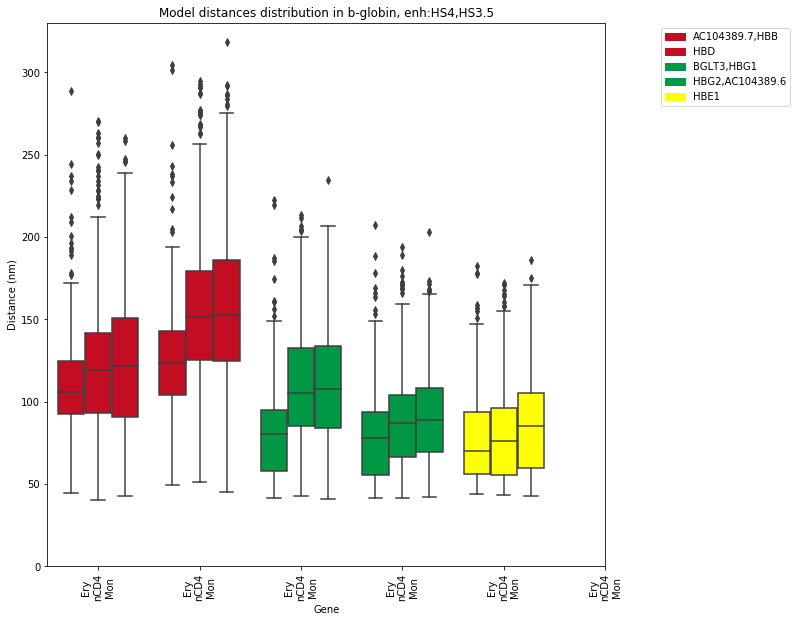

In [15]:
# secondary list of colors for each gene
colors = [(0.7647058823529411, 0.050980392156862744, 0.13725490196078433),
 (0.7647058823529411, 0.050980392156862744, 0.13725490196078433),
 (0, 0.596078431372549, 0.26666666666666666),
 (0, 0.596078431372549, 0.26666666666666666),
 (1.0, 1.0, 0.023529411764705882)]

saveFig = True
if saveFig == True:
    if toCluster == False:
        pdf = matplotlib.backends.backend_pdf.PdfPages(outplot + 'DistancesPromEnh.pdf')
    else:
        pdf = matplotlib.backends.backend_pdf.PdfPages(outplot + 'DistancesPromEnh_clustered.pdf')
else:
    pdf = []
    
for regi in sorted(distancesTemp.keys()):
    #if not os.path.exists(outpath + regi):
    #    os.makedirs(outpath + regi)
    
    cel_ = 'Ery'
    for enh in sorted(distancesTemp[regi][cel_].keys()):
        newDict = {}
        for cel in cells:
            if toCluster == False:
                if '-' in cel:
                    continue
            newDict[cel] = distancesTemp[regi][cel][enh]
            newDict2 = copy.copy(newDict)

            # to split by one promoter in each plot
            if toCluster == False:

                #realEnh = (enh * resol) + regiones[regi][1]
                realEnh = Enhinter[regi][enh]['name']

        title = 'Model distances distribution in %s, enh:%s' %(regi, realEnh)

        colors3 = []
        for f in colors:
            colors3 += [f] * len(orderCell)
        plotting.plotBoxplot(newDict2, saveFig=saveFig, title=title, meanDistance=False,
                      order=['AC104389.7,HBB', 'HBD', 'BGLT3,HBG1', 'HBG2,AC104389.6', 'HBE1'], 
                     orderCell=orderCell,
                   colors2=colors3, pdf=pdf)   

        plt.ylim(0,330)
        plt.show()
if saveFig == True:
    pdf.close()

## Get p-values 

In [16]:
for regi in sorted(distancesTemp.keys()):
    #if not os.path.exists(outpath + regi):
    #    os.makedirs(outpath + regi)
    
    cel_ = 'Ery'
    for enh in sorted(distancesTemp[regi][cel_].keys()):
        realEnh = Enhinter[regi][enh]['name']
        print '*' * 5, realEnh, '*' * 5
        newDict = {}
        for cel in cells:
            if toCluster == False:
                if '-' in cel:
                    continue
            newDict[cel] = distancesTemp[regi][cel][enh]
            newDict2 = copy.copy(newDict)
            
        cells = newDict2.keys()
        for gene in newDict2[newDict2.keys()[0]].keys():
            print '#' * 5, gene, '#' * 5

            combinations = itertools.combinations(cells, 2)
            for cell1, cell2 in combinations:
                print cell1, cell2

                stat1 = stats.ks_2samp(newDict2[cell1][gene], newDict2[cell2][gene])
                print stat1
                #stat1 = "p={:.2E}".format(Decimal(stat1[1])) + " s=%.2f" % round(stat1[0],2)
                #stat1 = statConvert(stat1)

***** HS4,HS3.5 *****
##### HBD #####
Mon nCD4
Ks_2sampResult(statistic=0.050999999999999934, pvalue=0.1440824352462374)
Mon Ery
Ks_2sampResult(statistic=0.36100000000000004, pvalue=1.1727333397653598e-57)
nCD4 Ery
Ks_2sampResult(statistic=0.35800000000000004, pvalue=1.0386480044592284e-56)
##### AC104389.7,HBB #####
Mon nCD4
Ks_2sampResult(statistic=0.052000000000000046, pvalue=0.1298437801612358)
Mon Ery
Ks_2sampResult(statistic=0.22799999999999998, pvalue=2.962869184240814e-23)
nCD4 Ery
Ks_2sampResult(statistic=0.18999999999999995, pvalue=2.8011558612659293e-16)
##### BGLT3,HBG1 #####
Mon nCD4
Ks_2sampResult(statistic=0.03200000000000003, pvalue=0.6785103823828891)
Mon Ery
Ks_2sampResult(statistic=0.38500000000000006, pvalue=1.6086825057325864e-65)
nCD4 Ery
Ks_2sampResult(statistic=0.38, pvalue=7.695894591186337e-64)
##### HBE1 #####
Mon nCD4
Ks_2sampResult(statistic=0.11699999999999994, pvalue=1.9469841454623217e-06)
Mon Ery
Ks_2sampResult(statistic=0.18400000000000005, pvalue=2.70